In [ ]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from graphviz import Digraph

from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from catboost import CatBoostRegressor
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1, palette="Set2")

---
### Задача 2.

Вам выдана часть информации о визитах пользователей на сайте Физтех.Статистики начиная с 2020 года по данным Яндекс.Метрики. Визит &mdash; последовательность действий пользователя на сайте, которая начинается на некоторой странице сайта, содержит в себе переходы по ссылкам (и другие действия), и заканчивается на какой-то, возможно, другой страницей сайта. Визит считается завершенным, если активность отсутствует в течение некоторого времени, обычно &mdash; 30 минут.

Описание полей доступно по <a href="https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits.html">ссылке</a>.

Ознакомьтесь с данными, ответив на следующие вопросы.
1. Сколько всего визитов представлено в данных?
2. Когда совершены первый и последний визиты?
3. Постройте динамику количества визитов во времени по дням.
4. Сколько уникальных пользователей в данных?
5. Сколько в среднем один пользователь совершил визитов? Сколько максимально?
6. Постройте гистограмму глубины и продолжительности визитов.
7. Из каких стран больше пользователей?
8. Какие браузеры и операционные системы в топе?

___

Считаем данные

In [1]:
data = pd.read_csv("data.tsv", sep="\t")
data.head()

NameError: name 'pd' is not defined

In [4]:
for column in data.columns:
    col = column.replace("ym:s:", "")
    data.rename(columns={column: col}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387353 entries, 0 to 387352
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   visitID              387353 non-null  float64
 1   clientID             387353 non-null  uint64 
 2   dateTimeUTC          387353 non-null  object 
 3   startURL             387338 non-null  object 
 4   endURL               387338 non-null  object 
 5   pageViews            387353 non-null  int64  
 6   visitDuration        387353 non-null  int64  
 7   isNewUser            387353 non-null  int64  
 8   bounce               387353 non-null  int64  
 9   regionCountry        382478 non-null  object 
 10  regionCity           326661 non-null  object 
 11  networkType          43035 non-null   object 
 12  browserLanguage      327934 non-null  object 
 13  browserCountry       224983 non-null  object 
 14  mobilePhone          73354 non-null   object 
 15  operatingSystemRo

Изменим тип на дату.

In [5]:
data["dateTimeUTC"] = pd.to_datetime(data["dateTimeUTC"])

## 1. Исследование данных

Решим пункты 1, 2, 4, 5.

In [6]:
print(f"Количество визитов: {len(data)}")
print(f'Первый визит: {data["dateTimeUTC"].min()}')
print(f'Последний визит: {data["dateTimeUTC"].max()}')
print(f'Уникальных пользователей: {data["clientID"].nunique()}')

visits_count = data.groupby(by="clientID").count().iloc[:, 0].tolist()
print(f"В среднем пользователь совершает визитов: {np.mean(visits_count):.2f}")
print(f"Максимум совершено визитов: {np.max(visits_count)}")

Количество визитов: 387353
Первый визит: 2020-01-01 03:28:50
Последний визит: 2024-02-25 23:58:46
Уникальных пользователей: 162474
В среднем пользователь совершает визитов: 2.38
Максимум совершено визитов: 58700


Разобьем время посещение на дату и на час, а также выделим год и месяц

In [7]:
data["hour"] = data["dateTimeUTC"].dt.hour
data["date"] = pd.to_datetime(data["dateTimeUTC"].dt.date)
data["year"] = data["date"].apply(lambda dt: dt.year)
data["month"] = data["date"].apply(lambda dt: dt.month)
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,WebKit,2,1920,1080,1905,981,3,2020-01-01,2020,1
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,Singapore,...,WebKit,1,375,667,375,559,10,2020-01-01,2020,1
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,WebKit,1,414,736,414,660,11,2020-01-01,2020,1
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,China,...,WebKit,1,412,892,412,756,11,2020-01-01,2020,1
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,Gecko,2,1920,1080,913,942,12,2020-01-01,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2024-02-25 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,WebKit,1,384,832,384,756,23,2024-02-25,2024,2
387349,8.349555e+17,1706366044539443064,2024-02-25 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,WebKit,2,1600,900,1583,771,23,2024-02-25,2024,2
387350,8.350287e+17,1707574597556843446,2024-02-25 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,WebKit,2,1536,864,1519,729,23,2024-02-25,2024,2
387351,8.350809e+17,17088943799001288,2024-02-25 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,WebKit,1,393,851,393,687,23,2024-02-25,2024,2


#### Количество визитов по часам

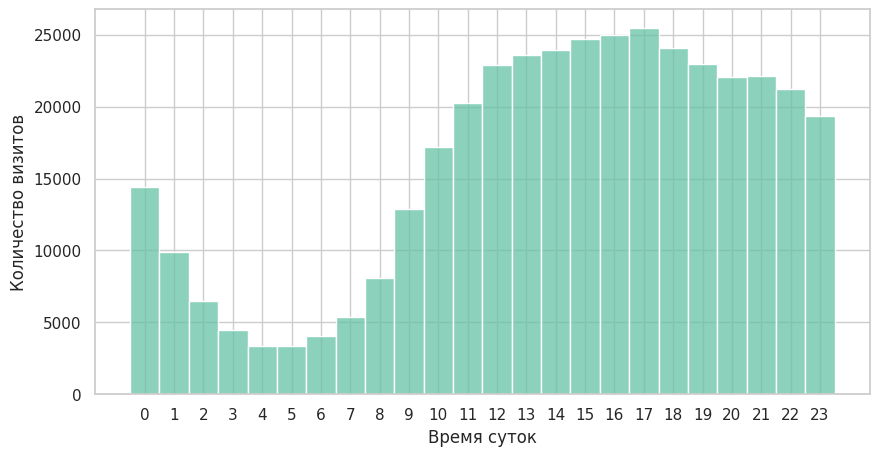

In [8]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 5))
    sns.histplot(data["hour"].astype(int), bins=range(25))
    plt.xlabel("Время суток")
    plt.ylabel("Количество визитов")
    plt.xticks(np.arange(24) + 0.5, range(24))
    plt.show()

#### Динамика количества визитов во времени по дням

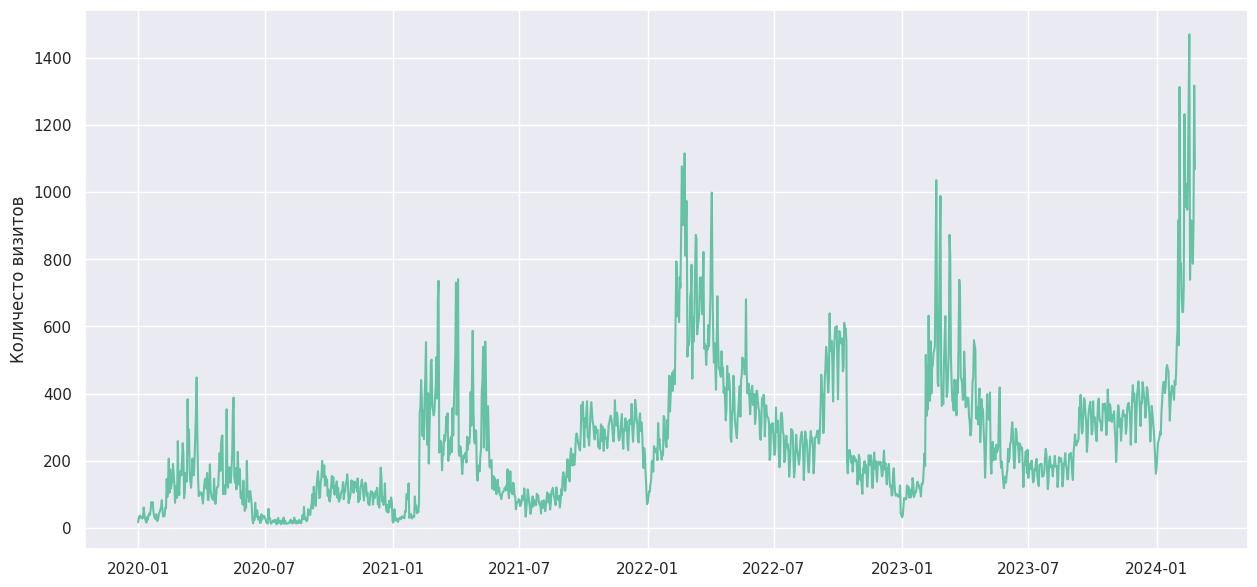

In [9]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(15, 7))
    plt.plot(data.groupby(by="date").count()["clientID"])
    plt.ylabel("Количесто визитов")
    plt.show()

Можем наблюдать наличие пиков-выбросов во временных периодах

####  Глубина и длительность просмотров

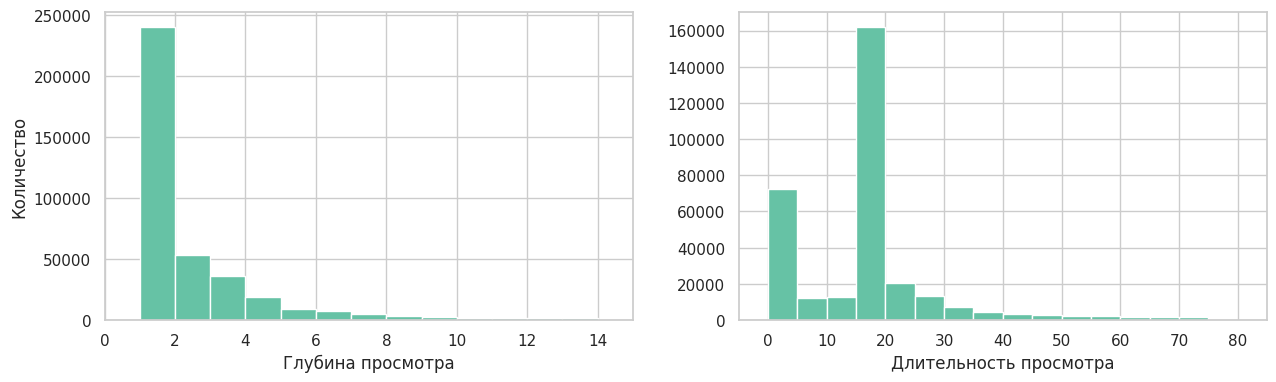

In [10]:
with sns.axes_style("whitegrid"):
    _, axes = plt.subplots(1, 2, figsize=(15, 4))

    axes[0].hist(data["pageViews"], bins=np.arange(1, 15))
    axes[0].set_xlabel("Глубина просмотра")
    axes[0].set_ylabel("Количество")
    axes[0].set_xlim((0, 15))

    axes[1].hist(data["visitDuration"], bins=np.arange(0, 80, 5))
    axes[1].set_xlabel("Длительность просмотра")
    axes[1].set_xlim((-5, 85))

    plt.show()

Есть явно выбросные значения. Странно, что длительность просмотра часто находится в пределах 15-20, но в бинах рядом значения принимаются сильно реже.

#### Топ браузеров

Cразу же будем заменять редко встречающиеся значения на `other`.

Самые популярные браузеры


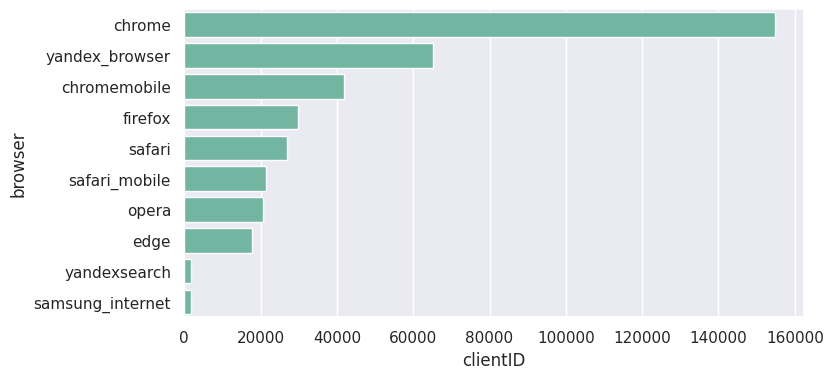

In [11]:
print("Самые популярные браузеры")
data["browser"] = data["browser"].astype(str)
x = (
    data.groupby(by="browser")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x.iloc[:10], orient="h");

In [12]:
browsers = [
    "chrome",
    "yandex_browser",
    "chromemobile",
    "firefox",
    "safari",
    "opera",
    "edge",
]
data.loc[~data["browser"].isin(browsers), "browser"] = "other"

#### Топ по странам

Самые частые страны


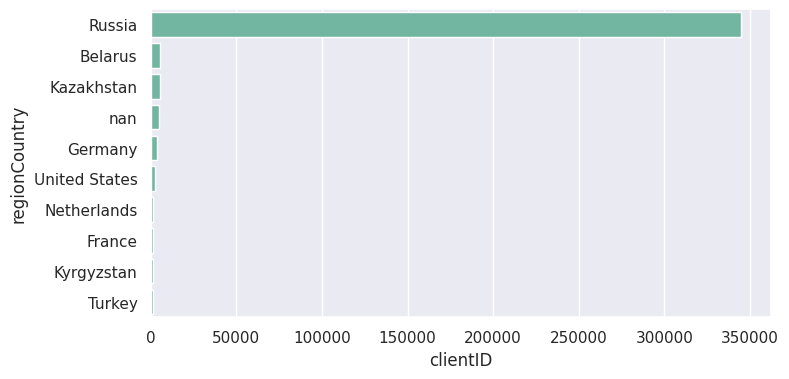

In [13]:
print("Самые частые страны")
data["regionCountry"] = data["regionCountry"].astype(str)
x = (
    data.groupby(by="regionCountry")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x.iloc[:10], orient="h");

In [14]:
data.loc[data["regionCountry"] != "Russia", "regionCountry"] = "other"
data

,visitID,clientID,dateTimeUTC,startURL,endURL,pageViews,visitDuration,isNewUser,bounce,regionCountry,...,browserEngine,screenOrientation,screenWidth,screenHeight,windowClientWidth,windowClientHeight,hour,date,year,month
0,1.801686e+19,1568056026568729022,2020-01-01 03:28:50,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,1,0,1,Russia,...,WebKit,2,1920,1080,1905,981,3,2020-01-01,2020,1
1,1.802359e+19,1577864187752491163,2020-01-01 10:36:27,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,9,215,1,0,other,...,WebKit,1,375,667,375,559,10,2020-01-01,2020,1
2,1.802460e+19,1567765219104836417,2020-01-01 11:40:44,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,88,0,0,Russia,...,WebKit,1,414,736,414,660,11,2020-01-01,2020,1
3,1.802475e+19,1576839432510419026,2020-01-01 11:50:13,https://mipt-stats.gitlab.io/jekyll/update/201...,https://mipt-stats.gitlab.io/jekyll/update/201...,1,19,0,0,other,...,WebKit,1,412,892,412,756,11,2020-01-01,2020,1
4,1.802518e+19,1576246599115183097,2020-01-01 12:17:33,https://mipt-stats.gitlab.io/,https://mipt-stats.gitlab.io/jekyll/update/201...,2,2,0,0,Russia,...,Gecko,2,1920,1080,913,942,12,2020-01-01,2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387348,8.349148e+17,170889374781031580,2024-02-25 23:42:27,https://miptstats.github.io/,https://miptstats.github.io/,1,15,1,0,Russia,...,WebKit,1,384,832,384,756,23,2024-02-25,2024,2
387349,8.349555e+17,1706366044539443064,2024-02-25 23:45:02,https://miptstats.github.io/courses/python/09_...,https://miptstats.github.io/courses/python/09_...,1,0,0,1,Russia,...,WebKit,2,1600,900,1583,771,23,2024-02-25,2024,2
387350,8.350287e+17,1707574597556843446,2024-02-25 23:49:41,https://miptstats.github.io/courses/ad_fivt/ta...,https://miptstats.github.io/courses/ad_fivt/ta...,1,0,0,1,Russia,...,WebKit,2,1536,864,1519,729,23,2024-02-25,2024,2
387351,8.350809e+17,17088943799001288,2024-02-25 23:52:59,https://mipt-stats.gitlab.io/courses/python/05...,https://mipt-stats.gitlab.io/courses/python/05...,1,23,1,0,Russia,...,WebKit,1,393,851,393,687,23,2024-02-25,2024,2


#### Топ по ОС

Самые популярные ОС


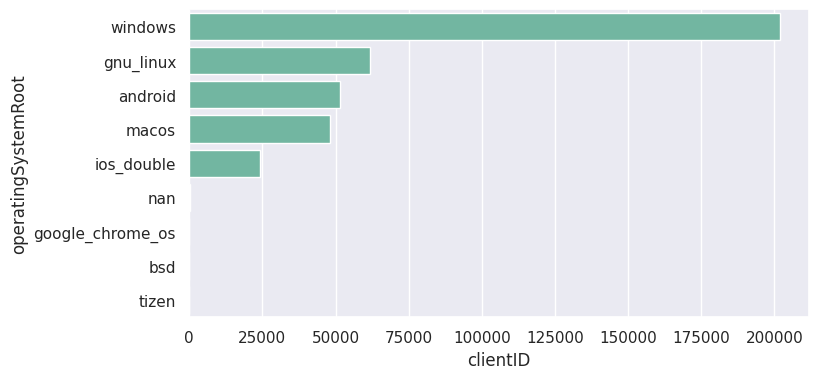

In [15]:
print("Самые популярные ОС")
data["operatingSystemRoot"] = data["operatingSystemRoot"].astype(str)
x = (
    data.groupby(by="operatingSystemRoot")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [16]:
os = ["windows", "gnu_linux", "android", "macos", "ios_double"]
data = data[data["operatingSystemRoot"].isin(os)]

#### Ориентации экрана

Самые популярные ориентации экрана


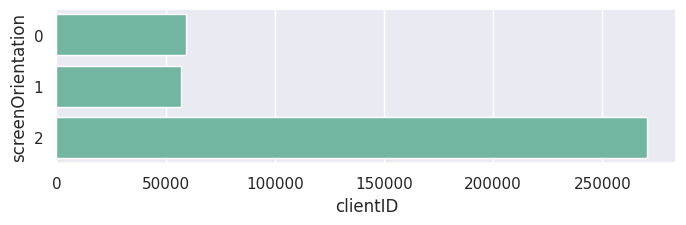

In [17]:
print("Самые популярные ориентации экрана")
x = (
    data.groupby(by="screenOrientation")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 2))
sns.barplot(x, orient="h");

#### Типы интернет-сетей

Самые популярные типы сетей


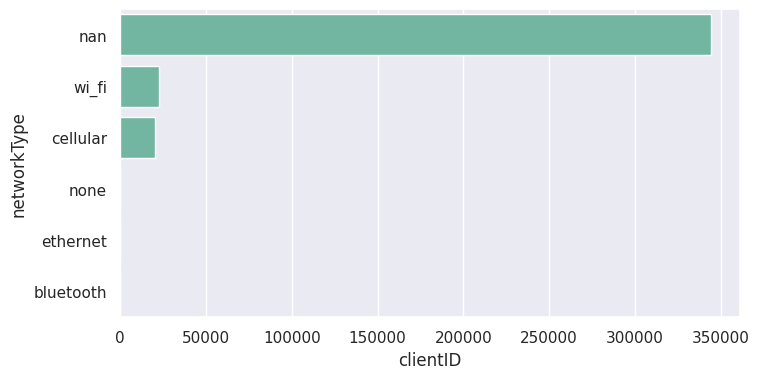

In [18]:
print("Самые популярные типы сетей")
data["networkType"] = data["networkType"].astype(str)
x = (
    data.groupby(by="networkType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [19]:
network_types = ["nan", "wi_fi", "cellular"]
data = data[data["networkType"].isin(network_types)]

#### Тип точки входа на сайт

Типы сайтов


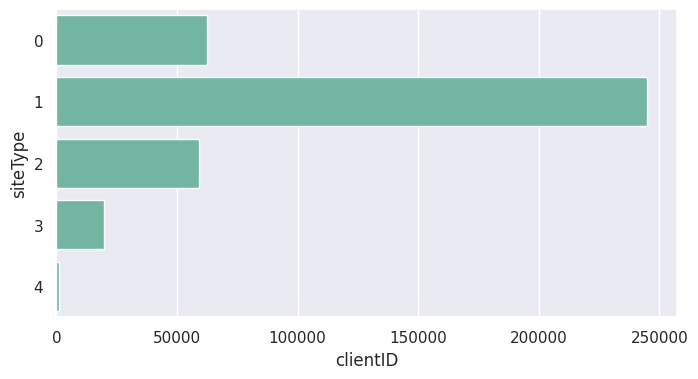

In [20]:
site_types = []
data["startURL"] = data["startURL"].astype(str)

for i in range(len(data)):
    if "github.io" in data["startURL"].iloc[i]:
        site_types.append(0)
    elif "gitlab.io" in data["startURL"].iloc[i]:
        site_types.append(1)
    elif "wiki.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(2)
    elif "forms.yandex.ru" in data["startURL"].iloc[i]:
        site_types.append(3)
    else:
        site_types.append(4)

data["siteType"] = site_types

print("Типы сайтов")
x = (
    data.groupby(by="siteType")
    .count()
    .sort_values("clientID", ascending=False)["clientID"]
)

plt.figure(figsize=(8, 4))
sns.barplot(x, orient="h");

In [21]:
data = data[data["siteType"].isin([0, 1])]

## 2. Дизайн теста


В апреле команда Физтех.Статистики планирует провести эксперимент продолжительностью 4 недели, покрасив фон всех страниц в розовый цвет, а также добавив к нему анимированных котиков и сердечек. *Гипотеза &mdash; средняя по посетителям глубина просмотра страниц вырастет на 5%.* Вам, как студентам DS-потока, предстоит задизайнить этот эксперимент. 

Выберите размеры групп на основе некоторых соображений.

----

Посмотрим на кол-во уникальных пользователей в каждом из месяцев.

In [22]:
data_cnt = (
    data.groupby(["year", "month"]).agg({"clientID": pd.Series.nunique}).reset_index()
)
data_cnt["date_month"] = data_cnt.apply(
    lambda row: pd.to_datetime(f"""{row['year']}-{row['month']}-01"""), axis=1
)
data_cnt.set_index("date_month", inplace=True)
data_cnt

,year,month,clientID
date_month,,,
2020-01-01,2020,1,340
2020-02-01,2020,2,859
2020-03-01,2020,3,1060
2020-04-01,2020,4,744
2020-05-01,2020,5,823
2020-06-01,2020,6,432
2020-07-01,2020,7,240
2020-08-01,2020,8,293
2020-09-01,2020,9,581


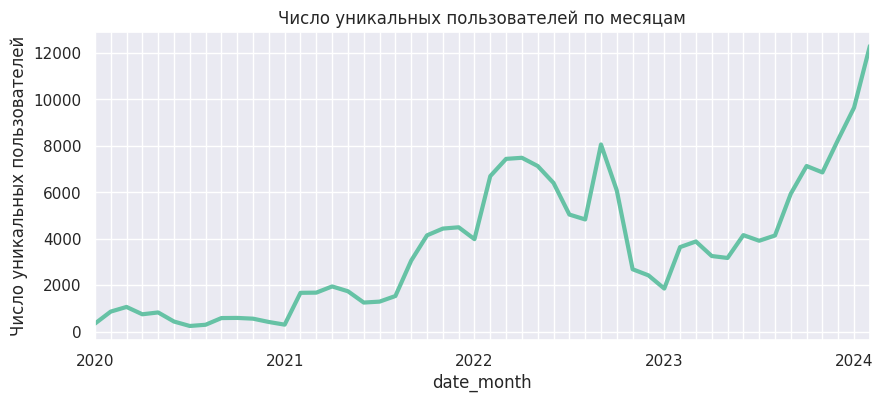

In [23]:
plt.figure(figsize=(10, 4))
data_cnt["clientID"].plot(lw=3)
plt.ylabel("Число уникальных пользователей")
plt.title("Число уникальных пользователей по месяцам")
plt.xticks(pd.date_range(start="2020-01-01", end="2024-02-01", freq="M"))
plt.show()

Количество визитов по посетителям

In [24]:
data.groupby(by="clientID")["visitID"].count().sort_values(ascending=False)

clientID
159631106194964144      525
1571345203385962128     379
1686212478710418142     286
167534681728506132      272
16456430291034906449    256
                       ... 
1663097040816887536       1
1663096684451168065       1
1663096176798996023       1
1663096086600001333       1
16910522111058091140      1
Name: visitID, Length: 152607, dtype: int64

Динамика целевой метрики

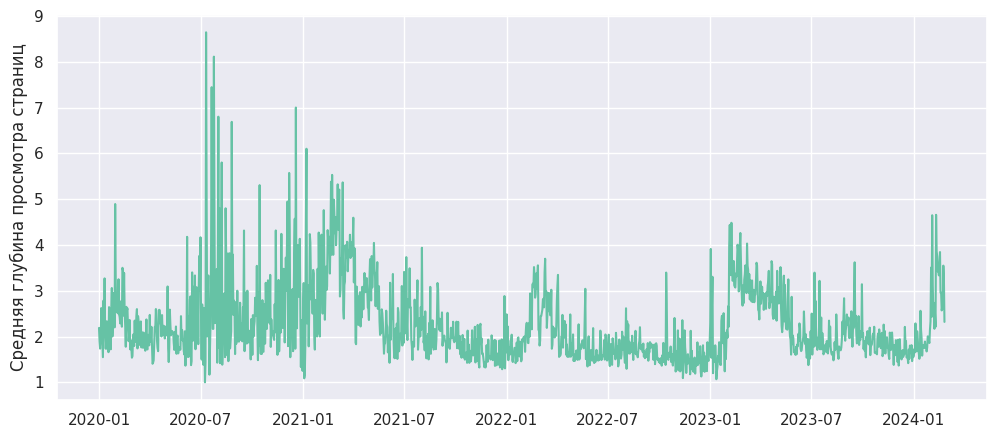

In [25]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 5))
    plt.plot(data.groupby(by="date")["pageViews"].mean())
    plt.ylabel("Средняя глубина просмотра страниц")
    plt.show()

Число уникальных пользователей со временем растет. Также видна сезонность: обычно сайт более популярен в феврале-марте, а также в сентябре-октябре. В апреле же популярность сайта несколько ниже, чем в феврале-марте. Оценим размер выборки снизу: будем считать, что в апреле посетит сайт не менее 8 тыс. уникальных пользователей.

Предположим, что у нас стоит строгое бизнес-ограничение — определить, есть ли эффект, за месяц. В таком случае мы не можем держать тест дольше, поэтому зафиксируем длительность теста. Возьмем период $T=28$ дней, для соблюдения периодичности недели и месяца. Зафиксируем размер теста+контроля 8 тыс. уникальных пользователей и будем сэмплировать 10 тыс. уникальных пользователей из этого промежутка. Далее будем 50% отправлять в тест, остальных — в контроль.

*Замечание:* далеко не факт, что мы сможем детектировать изменения в 5% на нужной мощности (обычно считают, что мощность должна быть 0.8). Однако, построив график мощности, мы сможем определить изменения, которые мы задетектим на нужной мощности.

In [26]:
test_control_size = 10_000  # пользователей в тесте+контроле
fraq_test = 0.5  # доля пользователей в тесте

# зададим промежуток времени, на котором валидируем
date_valid_start = pd.to_datetime("2024-01-01")
date_valid_end = pd.to_datetime("2024-02-29")
# зададим длительность теста
test_dlit = 28
# целевая метрика
target_column = "pageViews"

# размеры эффектов для оценки мощности
effects_list = np.linspace(0, 0.15, 16)

n_iter = 1_000  # количество итераций валидации
alpha = 0.05  # уровень значимости
n_jobs = 4  # количество параллельных потоков

---

Для абсолютного и относительного t-test проведите валидацию по историческим данным, семплируя момент времени начала эксперимента и сами группы пользователей. В рамках валидации оцените вероятность ошибки 1 рода и мощность критериев для ожидаемого эффекта.

Следите чтобы используемые интервалы времени не выходили за границы доступных данных. Возможно, на основе проведенного ранее первичного анализа данных стоит ограничить длину исторических данных, по которой будете проводить варидацию.

---

Распишите подробно поэтапный алгоритм валидации:

1. Серия АА-тестов на исторических данных:

    a. Делаем много раз следующие вещи:
    1. Семплируем дату
    2. Берем следующие 10к уникальных пользователей
    3. Делим случайно пользователей на 2 равные группы
    4. Проверяем критерий
    
    b. Считаем частоту отвержения критерия, дов. интервал для нее. Если теоретическая вероятность ошибки первого рода ($\alpha$) попадает в дов. интервал, то критерий корректен.
    
2. Серия АБ-тестов на исторических данных с искусственно добавленным эффектом:

    a. Для каждого размера эффекта делаем много раз следующие вещи:
    1. Семплируем дату
    2. Берем следующие 10к уникальных пользователей
    3. Делим случайно пользователей на 2 равные группы (подбрасываем монетку и если выпадает орел — то отправляем пользователя в тест, если решка — то в контроль)
    4. Искусственно добавляем эффект, равный размеру эффекта
    5. Проверяем критерий
    
    b. Считаем частоту отвержения критерия, дов. интервал для нее. Получаем оценку мощности

Возьмем реализацию с занятий и напишем абсолютный t-test.

In [27]:
def absolute_ttest(x, y):
    """
    Абсолютный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """
    res = sps.ttest_ind(x, y)
    stat, pvalue = res.statistic, res.pvalue
    left_bound, right_bound = res.confidence_interval()

    return stat, pvalue, left_bound, right_bound

In [28]:
def relative_ttest(x, y, alpha=0.05):
    """
    Относительный t-test.

    Аргументы:
    x, y -- выборки одинакового размера
    alpha -- уровень значимости

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    n = len(x)
    x_mean = x.mean()
    y_mean = y.mean()

    stat = x_mean / y_mean - 1
    var = x.var() / (y_mean**2) + y.var() * (x_mean**2) / (y_mean**4)
    std = np.sqrt(var)

    z_stat = np.sqrt(n) * stat / std
    pvalue = 2 * sps.norm.sf(np.abs(z_stat))

    q = sps.norm.ppf(1 - alpha / 2)
    left_bound = stat - q * std / np.sqrt(n)
    right_bound = stat + q * std / np.sqrt(n)

    return stat, pvalue, left_bound, right_bound

In [29]:
def estimate_reject_prob(n_rejects, n_iter):
    """
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    """

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method="wilson")

    return prob_reject, left_bound, right_bound


def visualization(
    prob_reject,
    left_bound,
    right_bound,
    show_pvals=False,
    pvals=None,
    alpha=0.05,
    figsize=(7, 2),
    title=None,
):
    """
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    """

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(
                pvals,
                bins=np.linspace(0, 1, 21),
                alpha=0.7,
                weights=np.ones(len(pvals)) / len(pvals),
            )
            plt.title("Распределение p-value")

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color="black", lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color="red", lw=5, linestyle="--", alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15] * 2, [-0.15] * 2, color="green", alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker="*", color="red")
        plt.xlim((min(alpha, left_bound) - 1e-3, max(alpha, right_bound) + 1e-3))
        plt.title(
            f"Доля отвержений = {100*prob_reject:.2f}%, "
            f"интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)"
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def draw_power(
    powers,
    left_powers,
    right_powers,
    effects_list=np.linspace(0, 0.1, 11),
    label=None,
    title="Графики мощности",
    new_figure=False,
):
    """
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    """

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(
            0.8,
            effects_list[0],
            effects_list[-1],
            color="black",
            alpha=0.5,
            label="Мощность 0.8 (пересечение — MDE)",
        )
    plt.legend()
    plt.xlabel("Размер относительного эффекта")
    plt.ylabel("Мощность")
    plt.title(title)

In [30]:
def add_effect(x, effect, target_name="pilot", relative_effect=True):
    """
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект

    Возвращает:
    x -- выборка с добавленным эффектом
    """

    x_copy = x.copy()
    if relative_effect:
        x_copy[target_name] *= 1 + effect
    else:
        x_copy[target_name] += effect

    return x_copy


def run_1_iteration(
    test,
    generate_samples,
    target_name,
    add_effect,
    effects_list=[0],
    relative_effect=True,
):
    """
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    add_effect -- функция добавления эффекта
    effects_list --  массив размеров добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает: pvalue
    """
    # Генерируем выборки
    x_data, y_data = generate_samples(data=data)

    pvals = []
    for effect in effects_list:
        # Добавляем эффект, если хотим оценить мощность
        x_data_cp = add_effect(
            x_data, effect, target_name=target_name, relative_effect=relative_effect
        )
        # Применяем критерий
        pvals.append(test(x_data_cp, y_data)[1])
    return pvals


def run_experiments(
    test,
    generate_samples,
    data=None,
    add_effect=add_effect,
    n_iter=10000,
    sample_size=1000,
    effect=0,
    relative_effect=True,
    n_jobs=4,
    alpha=0.05,
    target_name="pilot",
    draw=False,
    title=None,
    show_pvals=True,
):
    """
    Проведение серии AA-тестов на исторических данных.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """

    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test, generate_samples, target_name, add_effect, [effect], relative_effect
        )
        for _ in tqdm(range(n_iter), leave=False)
    )
    pvals = np.array(pvals).flatten()
    # Подсчет числа отвержений
    n_rejects = (pvals < alpha).sum()

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject,
            left_bound,
            right_bound,
            show_pvals,
            pvals,
            alpha,
            figsize,
            title,
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test,
    generate_samples,
    data=None,
    n_jobs=4,
    n_iter=10000,
    sample_size=1000,
    effects_list=np.linspace(0, 0.1, 11),
    relative_effect=True,
    alpha=0.05,
    target_name="pilot",
):
    """
    Проведение серии AA-тестов на исторических данных с добавением разных эффектов.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функция для семплирования выборок
    data -- исторические данные
    n_iter -- количество итераций
    sample_size -- размер выборок
    add_effect -- функция добавления эффекта
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя колонки с таргет-метрикой
    """
    # Проведение серии экспериментов
    pvals = Parallel(n_jobs=n_jobs)(
        delayed(run_1_iteration)(
            test,
            generate_samples,
            target_name,
            add_effect,
            effects_list,
            relative_effect,
        )
        for _ in tqdm(range(n_iter), leave=False)
    )

    # Подсчет числа отвержений
    n_rejects = (np.array(pvals) < alpha).sum(axis=0)

    # Оценка мощности
    powers, left_bounds, right_bounds = estimate_reject_prob(n_rejects, n_iter)

    return powers, left_bounds, right_bounds

Напишем функцию, отбирающую исторические данные и делящую выборку на тест и контроль.

In [31]:
def generate_subarray(
    data,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """
    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]

    # агрегируем результат
    agg_dict = {target_column: "mean"}
    test_groupped = test.groupby(user_column).agg(agg_dict)
    control_groupped = control.groupby(user_column).agg(agg_dict)

    return test_groupped, control_groupped

### 2.1. Проверка абсолютного и относительного теста на корректность и оценка их мощности

Корректность

Абсолютный


  0%|          | 0/1000 [00:00<?, ?it/s]

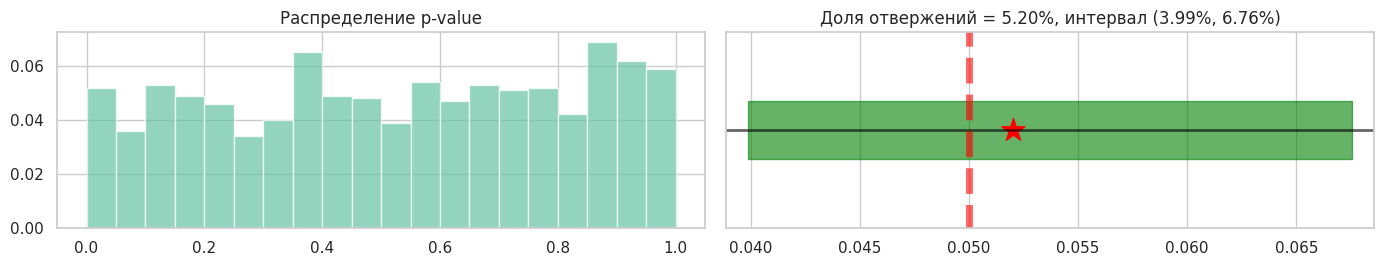

Относительный


  0%|          | 0/1000 [00:00<?, ?it/s]

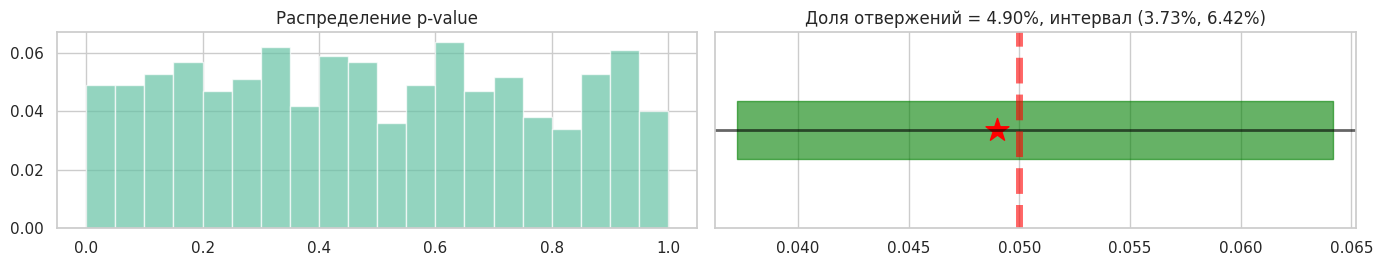

In [32]:
tests = [
    lambda x, y: absolute_ttest(x[target_column], y[target_column]),
    lambda x, y: relative_ttest(x[target_column], y[target_column]),
]
names = ["Абсолютный", "Относительный"]

for test, name in zip(tests, names):
    print(name)
    run_experiments(
        test=lambda x, y: absolute_ttest(x[target_column], y[target_column]),
        generate_samples=generate_subarray,
        target_name=target_column,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

Мощность

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

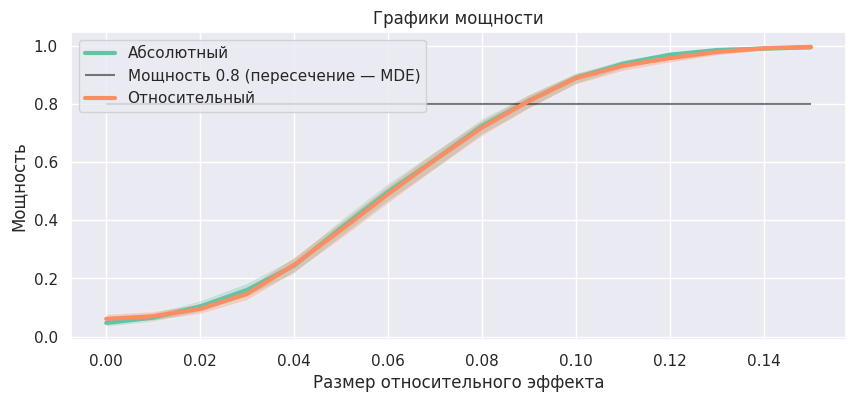

In [33]:
tests = [
    lambda x, y: absolute_ttest(x[target_column], y[target_column]),
    lambda x, y: relative_ttest(x[target_column], y[target_column]),
]
names = ["Абсолютный", "Относительный"]

for i, (test, name) in enumerate(zip(tests, names)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=generate_subarray,
        target_name=target_column,
        effects_list=effects_list,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    draw_power(
        powers,
        left_bounds,
        right_bounds,
        effects_list=effects_list,
        label=name,
        new_figure=(i == 0),
    )

**Вывод:** тесты работают корректно. Абсолютный тест имеет почти достигает достаточной мощности при эффекте в 10%.

### 2.2 Проверка регрессионных тестов из задания на корректность и подсчет их мощности

---

Провалидируйте и сравните следующие подходы к уменьшению дисперсии.
1. Стратификация по операционной системе. Редко встречающиеся операционные системы можно исключить или же объединить с какой-то другой стратой.
2. CUPED со стандартной ковариатой &mdash; значение исследуемой метрики для пользователя/бакета на предэкспериментальном периоде. Однако, в этом случае у нас нет соответствующих значений для новых пользователей. В таком случае можно сделать новый категориальный признак &mdash; имеется ли у пользователя активность во время предэкспериментального периода. Для тех, у кого не было активности, значение ковариаты можно заменить на константу. Далее использовать CUPED со стратификацией по дополнительному категориальному признаку.
3. Комбинация вариантов 1 и 2.
4. Рассмотрите также добавление других ковариат в методе CUPED.
5. CUPED, с прогнозом ML-модели в качестве ковариаты, предсказывающей целевую метрику на основе имеющихся признаков.

Во всех случаях можно использовать любые реализации методов понижения дисперсии, в том числе через линейную регрессию.


---

Реализуем функцию генерации данных с подсчетом стратификационных данных и ковариат (в том числе — и предсказанных).

In [36]:
# вещественные признаки для построения моделей
real_features = [
    "prepilot",
    "windowClientWidth",
    "windowClientHeight",
]

# категориальные признаки для построения моделей
cat_features = [
    "has_prepilot",
    "operatingSystemRoot",
    "browser",
    "regionCountry",
    "screenOrientation",
    "networkType",
]


def generate_subarray_covariates(
    data,
    agg_dict,
    date_valid_start=date_valid_start,
    date_valid_end=date_valid_end,
    test_dlit=test_dlit,
    test_control_size=test_control_size,
    fraq_test=fraq_test,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
    real_features=real_features,
    cat_features=cat_features,
    model=CatBoostRegressor(n_estimators=100, cat_features=cat_features, verbose=False),
    cuped=False,
    cupac=False,
):
    """
    Генерация выборок 2-x групп посредством случайного деления пользователей на 2 равные группы
    Агрегация данных по пользователям

    Аргументы:
    data -- данные
    date_valid_start, date_valid_end -- временные границы валидации
    test_dlit -- длительность истории, которую берем в тест
    test_control_size -- размер теста+контроля
    fraq_test -- доля тестовой группы
    cuped -- будет ли cuped
    cupac -- будет ли cupac

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные по тесту и контролю
    """

    # определяем временные границы теста
    all_days = (date_valid_end - date_valid_start).days - test_dlit
    diff_from_start = np.random.choice(all_days, 1)[0]
    start_date = date_valid_start + pd.to_timedelta(diff_from_start, "D")
    end_date = start_date + pd.to_timedelta(test_dlit, "D")

    # берем нужный срез данных по времени
    data_start_end = data[
        (data[date_column] >= start_date) & (data[date_column] < end_date)
    ]

    # из всех пользователей выбираем тест и контроль
    users = data_start_end[user_column].unique()
    test_size = int(test_control_size * fraq_test)
    control_size = test_control_size - test_size
    test_users = np.random.choice(users, test_size, replace=False)
    other_users = list(set(users) - set(test_users))
    control_users = np.random.choice(
        other_users, min(control_size, len(other_users)), replace=False
    )

    # берем нужный срез данных по пользователям
    test = data_start_end[data_start_end[user_column].isin(test_users)]
    control = data_start_end[data_start_end[user_column].isin(control_users)]

    # агрегируем данные
    test_groupped = test.groupby(user_column).agg(agg_dict)
    control_groupped = control.groupby(user_column).agg(agg_dict)

    # возвращаем данные в нужном виде
    if cuped:
        test_groupped = count_prepilot_metric(
            data,
            test_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )
        control_groupped = count_prepilot_metric(
            data,
            control_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
        )

        return test_groupped, control_groupped
    if cupac:
        return count_cupac_metric(
            data,
            agg_dict,
            test_groupped,
            control_groupped,
            start_date,
            test_dlit=test_dlit,
            date_column=date_column,
            user_column=user_column,
            target_column=target_column,
            real_features=real_features,
            cat_features=cat_features,
            model=model,
        )
    return test_groupped, control_groupped

Функция подсчета метрики на препилоте

In [37]:
def count_prepilot_metric(
    data,
    group,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Считаем метрику на препилоте

    Аргументы:
    data -- данные
    group -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    group -- сгруппированные данные c метрикой на препилоте
    """

    # берем нужный срез по датам
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")

    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # берем нужный срез по пользователям
    users = group.index.unique()
    prepilot_group = prepilot[prepilot[user_column].isin(users)]

    # группируем данные
    prepilot_groupped = prepilot_group.groupby(user_column)[[target_column]].mean()

    # заполняем данными препилота
    group["prepilot"] = prepilot_groupped[target_column]
    group["has_prepilot"] = group["prepilot"].apply(lambda x: 0 if pd.isnull(x) else 1)
    group["prepilot"].fillna(0, inplace=True)

    return group

Сбор данных для трейна модели предсказания для CUPAC

In [38]:
def collect_train_for_cupac(
    data,
    agg_dict,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
):
    """
    Собираем данные трейна для метода СUPAC

    Аргументы:
    data -- данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    prepilot_groupped -- сгруппированные данные препилота для обучения СUPAC
    """
    # берем нужный срез препилота по времени
    prepilot_start_date = start_date - pd.to_timedelta(test_dlit, "D")
    prepilot_end_date = start_date - pd.to_timedelta(1, "D")
    prepilot = data[
        (data[date_column] >= prepilot_start_date)
        & (data[date_column] < prepilot_end_date)
    ]

    # агрегируем данные
    prepilot_groupped = prepilot.groupby(user_column).agg(agg_dict)
    # добавляем данные препилота
    prepilot_groupped = count_prepilot_metric(
        data,
        prepilot_groupped,
        prepilot_start_date,
        test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    return prepilot_groupped

Функция подсчета предсказания, чтобы использовать CUPAC

In [39]:
def count_cupac_metric(
    data,
    agg_dict,
    test_groupped,
    control_groupped,
    start_date,
    test_dlit=28,
    date_column="date",
    user_column="clientID",
    target_column="pageViews",
    real_features=real_features,
    cat_features=cat_features,
    model=CatBoostRegressor(n_estimators=200, cat_features=cat_features, verbose=False),
):
    """
    Считаем CUPAC-метрику

    Аргументы:
    data -- данные
    test_groupped, control_groupped -- сгруппированные данные
    start_date -- дата старта теста
    test_dlit -- длительность истории, которую берем в тест

    Возвращает:
    test_groupped, control_groupped -- сгруппированные данные c метрикой на препилоте
    """
    # добавляем метрики препилота в тест и контроль
    test_groupped = count_prepilot_metric(
        data,
        test_groupped,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    control_groupped = count_prepilot_metric(
        data,
        control_groupped,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )
    # создаем трейн для модели
    train = collect_train_for_cupac(
        data,
        agg_dict,
        start_date,
        test_dlit=test_dlit,
        date_column=date_column,
        user_column=user_column,
        target_column=target_column,
    )

    # фичи для модели
    features = real_features + cat_features

    # обучаем модель на трейне
    model.fit(train[features], train[target_column])

    test_groupped["model_predicted"] = model.predict(test_groupped[features])
    control_groupped["model_predicted"] = model.predict(control_groupped[features])

    return test_groupped, control_groupped

Регрессионный t-test. Есть возможность сделать стратификацию, CUPED и CUPAC по нескольким колонкам

In [40]:
def regression_ttest(
    x_data,
    y_data,
    cuped=False,
    stratified=False,
    sample_name="pilot",
    treatment_name="treatment",
    covariate_names=[],
    strat_names=[],
):
    """
    T-test с CUPED/без CUPED, со стратификацией/без реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param stratified: применять ли стратификацию
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат
    :param strat_names: массив имен стратификационных столбцов

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    """

    x_data_cp = x_data.copy()
    y_data_cp = y_data.copy()

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])
    # удаляем ненужные столбцы из датасета
    if not cuped:
        covariate_names = []
    if not stratified:
        strat_names = []
    data = data[
        [treatment_name] + list(covariate_names) + list(strat_names) + [sample_name]
    ]

    # делаем стратификацию по нужным фичам
    data = pd.get_dummies(data, columns=strat_names)

    # определяем имена фичей, на которых будем обучать модель
    feature_names = list(set(data.columns) - set([sample_name]))

    # обучаем модель
    model = ols(f"{sample_name} ~ " + "+".join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, "t"]
    pvalue = summary.loc[treatment_name, "P>|t|"]
    left_bound = summary.loc[treatment_name, "[0.025"]
    right_bound = summary.loc[treatment_name, "0.975]"]
    return stat, pvalue, left_bound, right_bound

Проведение валидации

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

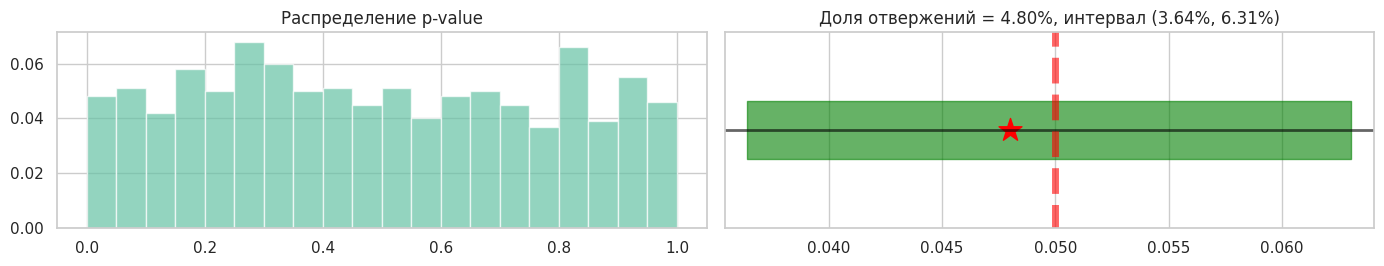

Cтрат по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

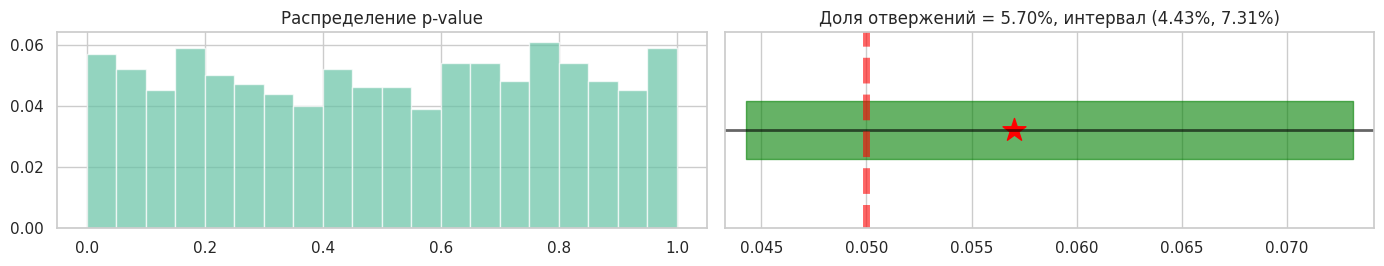

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

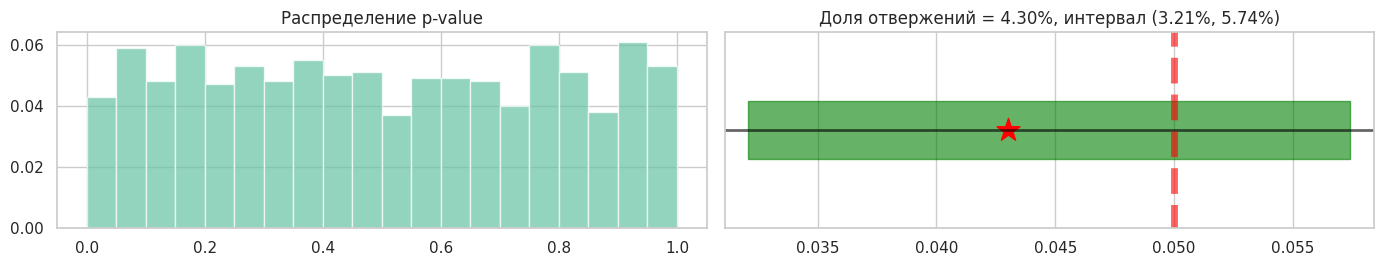

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

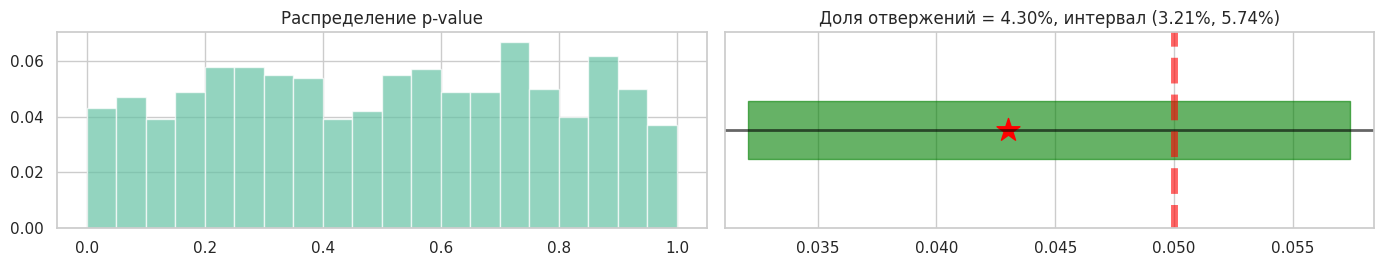

СUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

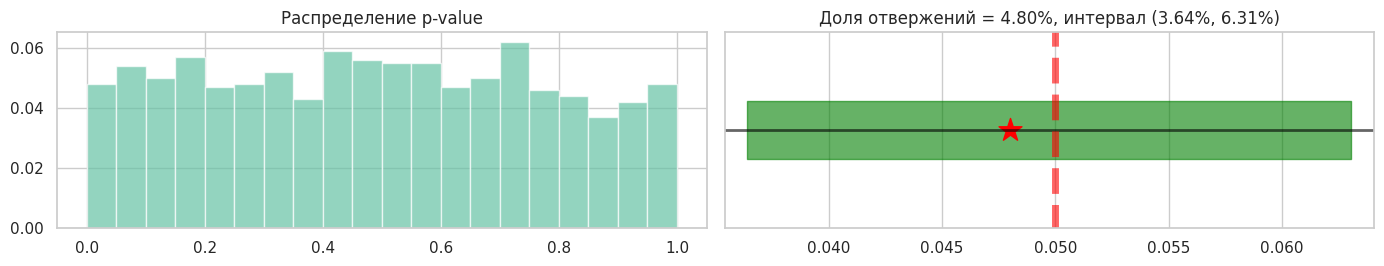

In [41]:
agg_dict = {
    "pageViews": "mean",
    "operatingSystemRoot": lambda x: x.iloc[0],
    "browser": lambda x: x.iloc[0],
    "regionCountry": lambda x: x.iloc[0],
    "screenOrientation": lambda x: x.iloc[0],
    "networkType": lambda x: x.iloc[0],
    "siteType": lambda x: x.iloc[0],
    "windowClientWidth": "mean",
    "windowClientHeight": "mean",
}

tests = [
    lambda x, y: regression_ttest(
        x, y, cuped=False, stratified=False, sample_name=target_column
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=False,
        stratified=True,
        strat_names=["operatingSystemRoot"],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot"],
        strat_names=["has_prepilot"],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x,
        y,
        cuped=True,
        stratified=True,
        covariate_names=["prepilot", "windowClientWidth", "windowClientHeight"],
        strat_names=[
            "has_prepilot",
            "operatingSystemRoot",
            "browser",
            "regionCountry",
            "screenOrientation",
            "networkType",
            "siteType",
        ],
        sample_name=target_column,
    ),
    lambda x, y: regression_ttest(
        x, y, cuped=True, covariate_names=["model_predicted"], sample_name=target_column
    ),
]

generate_samples_list = [
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cuped=True),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cuped=True),
    lambda data: generate_subarray_covariates(data, agg_dict=agg_dict, cupac=True),
]
names = [
    "Простой t-test",
    "Cтрат по ОС",
    "CUPED по препилоту",
    "CUPED по нескольким ковариатам",
    "СUPAC: CatBoostRegressor",
]

for test, generate_samples, name in zip(tests, generate_samples_list, names):
    print(name)
    run_experiments(
        test=test,
        generate_samples=generate_samples,
        target_name=target_column,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        show_pvals=True,
        draw=True,
        n_jobs=n_jobs,
    );

Простой t-test


  0%|          | 0/1000 [00:00<?, ?it/s]

Cтрат по ОС


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по препилоту


  0%|          | 0/1000 [00:00<?, ?it/s]

CUPED по нескольким ковариатам


  0%|          | 0/1000 [00:00<?, ?it/s]

СUPAC: CatBoostRegressor


  0%|          | 0/1000 [00:00<?, ?it/s]

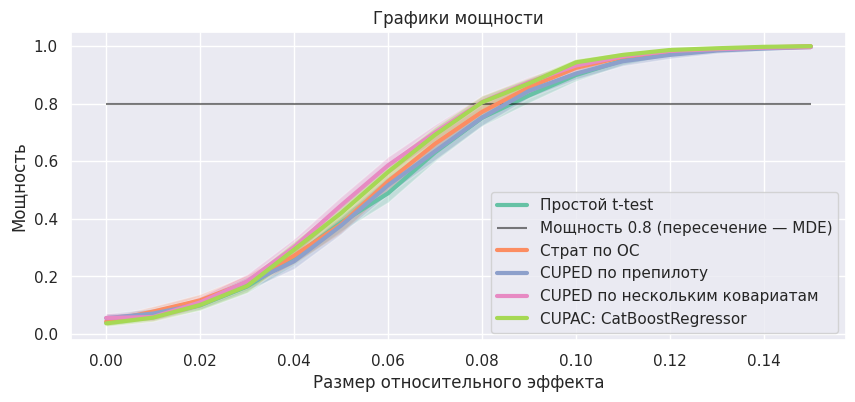

In [42]:
powers_list = []
left_bounds_list = []
right_bounds_list = []

for i, (test, generate_samples, name) in enumerate(
    zip(tests, generate_samples_list, names)
):
    print(name)
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples=generate_samples,
        target_name=target_column,
        effects_list=effects_list,
        data=data,
        n_iter=n_iter,
        alpha=alpha,
        n_jobs=n_jobs,
    )
    powers_list.append(powers)
    left_bounds_list.append(left_bounds)
    right_bounds_list.append(right_bounds)
    draw_power(
        powers,
        left_bounds,
        right_bounds,
        effects_list=effects_list,
        label=name,
        new_figure=(i == 0),
    )

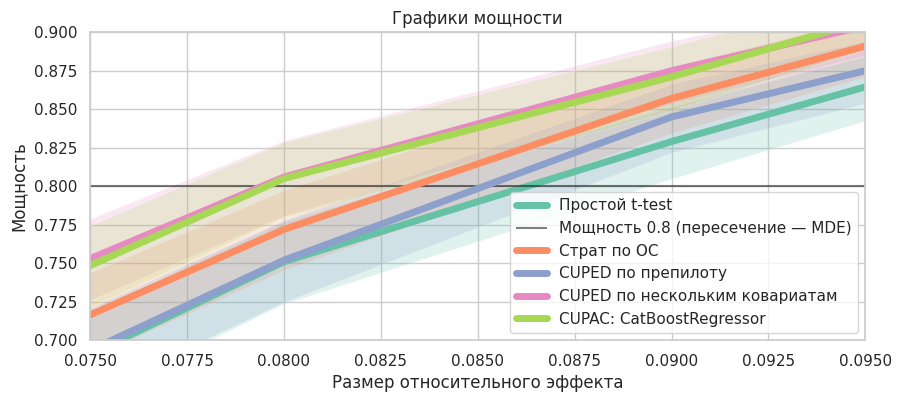

In [49]:
with sns.axes_style("whitegrid"):
    for i in range(len(tests)):
        draw_power(
            powers_list[i],
            left_bounds_list[i],
            right_bounds_list[i],
            effects_list=effects_list,
            label=names[i],
            new_figure=(i == 0),
        )
        plt.xlim((0.075, 0.095))
        plt.ylim((0.7, 0.9))

**Вывод:** мы проверили корректность и мощность абсолютного и относительного т-теста и проверили, как в данном случае работают методы уменьшения дисперсии. Они в данном случае помогли, но не сильно: MDE удалось уменьшить примерно на 0.7%.